In [1]:
# ! pip install -r requirements.txt

In [2]:
! pip install sc

ERROR: Could not find a version that satisfies the requirement sc (from versions: none)
ERROR: No matching distribution found for sc


In [27]:
import pypropep as ppp
import streamlit as st
import cffi as ffi
import pandas as pd
import numpy as np
import scipy as sp 
import skimpy
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import constants

In [4]:
ppp.init()

Loaded 1921 thermo species
Loaded 1031 propellants


In [5]:
performance = ppp.ShiftingPerformance()

ox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
fuel = ppp.PROPELLANTS['RP-1 (RPL)']
OF = 2.2
performance.add_propellants_by_mass([(fuel, 1.0), (ox, OF)])
performance.set_state(P=27., Pe=1)
# print(performance)    
# ox.mw
# 1/fuel.mw
# 2.2/ox.mw
# print(fuel['name'], fuel.formula())
# performance.properties_computed
# performance._equil_structs[2]
# performance._equil_objs[0].properties.density

In [6]:
def pypropep_to_dataframe(p, ox, fuel):

    Parameters = ['of (wt ratio)', 'p (psi)', 't (K)', 'rho (kg/m^3)', 'v (m/s)', 'Isp (s)', 'Ivac (m/s)', 'c* (m/s)', 'cf', 'sound (m/s)', 'A/At', 'cp (kJ/kg-K)', 'cv (kJ/kg-K)', 'gamma', 'mol mass (g/mol)', 
              'h (kJ/kg)', 'u (kJ/kg)', 'g (kJ/kg)', 's (kJ/kg-K)', 'dV_P', 'dV_T', 'composition']
    positions = ['chamber', 'throat', 'exit']

    df = pd.DataFrame(columns=Parameters, index=positions, dtype=float)

    df.attrs = {'ox' : [ox.formula(), ox['name'], ox['id']], 
                'fuel' : [fuel.formula(), fuel['name'], fuel['id']]}

    for i, c in enumerate(positions):
        composition = p.composition[c][0:8]
        if(bool(p.composition_condensed[c])):
            composition.append(p.composition_condensed[c])

        df.loc[c, 'of (wt ratio)']      = p._equil_structs[0].propellant.coef[1] * ox.mw
        df.loc[c, 'p (psi)']            = p._equil_objs[i].properties.P
        df.loc[c, 't (K)']              = p._equil_objs[i].properties.T
        df.loc[c, 'rho (kg/m^3)']       = (p._equil_objs[i].properties.P * 101325 * p._equil_objs[i].properties.M / 1000) / (p._equil_objs[i].properties.T * 8.314 ) # rho (kg/m^3) = (P (atm) * 101325 (Pa) / 1 (atm) * M (g/mol) * 1 kg/1000 g)/( T (K) * R (m^3-Pa/mol-k))
        df.loc[c, 'v (m/s)']            = p._equil_structs[i].performance.Isp
        df.loc[c, 'Isp (s)']            = p._equil_structs[i].performance.Isp/constants.g
        df.loc[c, 'Ivac (m/s)']         = p._equil_structs[i].performance.Ivac
        df.loc[c, 'c* (m/s)']           = p._equil_structs[i].performance.cstar
        df.loc[c, 'cf']                 = p._equil_structs[i].performance.cf
        df.loc[c, 'sound (m/s)']        = p._equil_structs[i].performance.ae_at
        df.loc[c, 'A/At']               = p._equil_objs[i].properties.Vson
        df.loc[c, 'cp (kJ/kg-K)']       = p._equil_objs[i].properties.Cp
        df.loc[c, 'cv (kJ/kg-K)']       = p._equil_objs[i].properties.Cv
        df.loc[c, 'gamma']              = p._equil_objs[i].properties.Isex
        df.loc[c, 'mol mass (g/mol)']   = p._equil_objs[i].properties.M
        df.loc[c, 'h (kJ/kg)']          = p._equil_objs[i].properties.H
        df.loc[c, 'u (kJ/kg)']          = p._equil_objs[i].properties.U
        df.loc[c, 'g (kJ/kg)']          = p._equil_objs[i].properties.G
        df.loc[c, 's (kJ/kg-K)']        = p._equil_objs[i].properties.S
        df.loc[c, 'dV_P']               = p._equil_objs[i].properties.dV_P
        df.loc[c, 'dV_T']               = p._equil_objs[i].properties.dV_T
        # df.at[c, 'composition']         = [composition]

    return df

In [7]:
performance = ppp.FrozenPerformance()

ox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
fuel = ppp.PROPELLANTS['RP-1 (RPL)']
OF_list = list(np.arange(1, 4, 0.2))
OF = 2.2
# print(type(OF))
# print(type(ox.mw))
# print(OF/ ox.mw)
performance.add_propellants_by_mass([(fuel, 1.0), (ox, OF)])
performance.set_state(P=27., Pe=1)
# performance.add_propellants([(fuel, 1.0), (ox, 2.3)])

print(fuel.mw)
print(ox.mw)


1397.6182999999999
31.9988


In [8]:
# DEFINE 
def ranged_sim(ox, fuel, of_arr, p_arr , p_e = 1, assumption = 'SHIFTING'):

    # iterates through OF ratios and pressures. 
    df_list = [] 
    o = ppp.PROPELLANTS[ox]
    f = ppp.PROPELLANTS[fuel]

    if assumption == 'SHIFTING':
        for p in p_arr:
            for of in of_arr:
                # print(p, of)
                performance = ppp.ShiftingPerformance()
                performance.add_propellants_by_mass([(f, 1.0), (o, of)])
                performance.set_state(P=p, Pe=p_e)
                df = pypropep_to_dataframe(performance, o, f)
                df_list.append(df)
        
    elif assumption == 'FROZEN':
        for p in p_arr:
            for of in of_arr:
                # # print(p, of)
                # print(f)
                performance = ppp.FrozenPerformance()
                performance.add_propellants_by_mass([(f, 1.0), (o, of)])
                performance.set_state(P = p, Pe = p_e)
                # print(performance)
                df = pypropep_to_dataframe(performance, o, f)
                df_list.append(df)    
                  
    else: 
        raise Exception('invalid assumption, options are \'SHIFTING\' or \'FROZEN\'')
        
    results = pd.concat(df_list, keys = list(range(len(df_list)))) 
    
    # if not a list of dataframes is output
    return results
            


In [9]:
def heatmap_generator(df, pos, var):
    # Parameters = ['of (wt ratio)', 'p (psi)', 't (K)', 'rho (kg/m^3)', 'v (m/s)', 'Isp (s)', 'Ivac (m/s)', 'c* (m/s)', 'cf', 'sound (m/s)', 'A/At', 'cp (kJ/kg-K)', 'cv (kJ/kg-K)', 'gamma', 'mol mass (g/mol)', 
    #           'h (kJ/kg)', 'u (kJ/kg)', 'g (kJ/kg)', 's (kJ/kg-K)', 'dV_P', 'dV_T', 'composition']
    # positions = ['chamber', 'throat', 'exit']
    # filtered = df.loc[:, [  'of (wt ratio)','p (psi)', var]]
    core = df.loc[pd.IndexSlice[:, 'chamber'], ['of (wt ratio)', 'p (psi)']]
    core.index = core.index.droplevel(1)
    param = df.loc[pd.IndexSlice[:, pos], var]
    param.index = param.index.droplevel(1)

    output = core.copy()
    output[var] = param
    # output = pd.DataFrame()
    # output['of (wt ratio)'] = core['of (wt ratio)']
    return output

In [10]:
%%time
performance = ppp.ShiftingPerformance()

ox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
fuel = ppp.PROPELLANTS['RP-1 (RPL)']
OF = 2.2

performance.add_propellants_by_mass([(fuel, 1.0), (ox, OF)])
performance.set_state(P=27., Pe=1)
# performance.add_propellants([(fuel, 1.0), (ox, 2.3)])

single = pypropep_to_dataframe(performance, ox, fuel)
single

CPU times: total: 0 ns
Wall time: 26.2 ms


,of (wt ratio),p (psi),t (K),rho (kg/m^3),v (m/s),Isp (s),Ivac (m/s),c* (m/s),cf,sound (m/s),...,cv (kJ/kg-K),gamma,mol mass (g/mol),h (kJ/kg),u (kJ/kg),g (kJ/kg),s (kJ/kg-K),dV_P,dV_T,composition
chamber,2.2,27.000000,3434.334430,2.072509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.531233,1.146957,21.630600,-751.530576,-2071.642257,-42064.919582,12.029518,-1.025494,1.459456,NaN
throat,2.2,15.515926,3236.991413,1.278857,1188.206952,121.163389,2222.889155,1800.499697,0.659932,1.000000,...,4.056712,1.148379,21.891682,-1457.446593,-2686.863179,-40396.894085,12.029518,-1.018866,1.360340,NaN
exit,2.2,1.000000,2240.964607,0.122923,2650.170526,270.242185,2961.224313,1800.499697,1.471908,4.816033,...,1.879779,1.203982,22.602805,-4263.232486,-5087.578063,-31220.957150,12.029518,-1.000939,1.024276,NaN


In [11]:
show = ranged_sim('OXYGEN (LIQUID)', 'RP-1 (RPL)', list(np.arange(1, 4, 0.2)), list(np.arange(10., 60., 2.5)), assumption='FROZEN')

show

of (wt ratio)    p (psi)        t (K)  rho (kg/m^3)      v (m/s)  \
0   chamber            1.0  10.000000  1501.824944      1.242570     0.000000   
    throat             1.0   5.433631  1301.289041      0.779214   962.876554   
    exit               1.0   1.000000   857.847543      0.217535  1699.395761   
1   chamber            1.2  10.000000  1788.842915      1.060780     0.000000   
    throat             1.2   5.420839  1545.097522      0.665745  1043.324027   
...                    ...        ...          ...           ...          ...   
298 throat             3.6  32.379027  3313.559347      3.100940  1129.959107   
    exit               3.6   1.000000  1782.247929      0.178056  2604.887188   
299 chamber            3.8  57.500000  3635.666500      5.095896     0.000000   
    throat             3.8  32.385709  3297.592984      3.164413  1118.405790   
    exit               3.8   1.000000  1776.182153      0.181405  2579.491103   

                Isp (s)   Ivac (m/s)     c* (m/s)        cf  sound (m/s)  ...  \
0   chamber    0.000000     0.000000     0.000000  0.000000     0.000000  ...   
    throat    98.186083  1696.724827  1350.566879  0.712943     1.000000  ...   
    exit     173.290141  1973.501858  1350.566879  1.258283     2.029563  ...   
1   chamber    0.000000     0.000000     0.000000  0.000000     0.000000  ...   
    throat   106.389443  1834.153074  1458.868224  0.715160     1.000000  ...   
...                 ...          ...          ...       ...          ...  ...   
298 throat   115.223762  2066.336578  1662.857380  0.679529     1.000000  ...   
    exit     265.624570  2823.360367  1662.857380  1.566513     7.554591  ...   
299 chamber    0.000000     0.000000     0.000000  0.000000     0.000000  ...   
    throat   114.045652  2045.671375  1646.336369  0.679330     1.000000  ...   
    exit     263.034890  2796.041990  1646.336369  1.566807     7.563264  ...   

             cv (kJ/kg-K)     gamma  mol mass (g/mol)    h (kJ/kg)  \
0   chamber      2.259528  1.277290         15.312057  -958.777275   
    throat       1.739884  1.312092         15.312057 -1422.342857   
    exit         1.591201  1.341254         15.312057 -2402.750250   
1   chamber      1.746469  1.306933         15.570076  -908.535514   
    throat       1.672537  1.319279         15.570076 -1452.797916   
...                   ...       ...               ...          ...   
298 throat       1.544563  1.206735         26.038606 -1284.811638   
    exit         1.386278  1.230340         26.038606 -4039.123967   
299 chamber      5.903593  1.127969         26.438095  -636.393580   
    throat       1.525663  1.206133         26.438095 -1261.813455   
    exit         1.369571  1.229626         26.438095 -3963.280756   

               u (kJ/kg)     g (kJ/kg)  s (kJ/kg-K)  dV_P  dV_T  composition  
0   chamber -1774.274390 -20796.258657    13.208917  -1.0   1.0          NaN  
    throat  -2128.948152 -18179.948826    12.877697  -1.0   1.0          NaN  
    exit    -2868.564991 -13733.987452    13.208917  -1.0   1.0          NaN  
1   chamber -1863.787899 -24947.717126    13.438397  -1.0   1.0          NaN  
    throat  -2277.888862 -21711.200678    13.111407  -1.0   1.0          NaN  
...                  ...           ...          ...   ...   ...          ...  
298 throat  -2342.879888 -35590.691570    10.353181  -1.0   1.0          NaN  
    exit    -4608.221952 -22817.878933    10.536556  -1.0   1.0          NaN  
299 chamber -1779.773436 -38476.118951    10.407920  -1.0   1.0          NaN  
    throat  -2298.872655 -34987.550981    10.227380  -1.0   1.0          NaN  
    exit    -4521.871840 -22449.642141    10.407920  -1.0   1.0          NaN  

[900 rows x 22 columns]

In [12]:
filtered = heatmap_generator(show, 'exit', 'Isp (s)')
filtered.convert_dtypes(infer_objects=True)
filtered.dtypes
filtered.iloc[1,1]

10.0

In [13]:
exam = pd.pivot(filtered, index='of (wt ratio)', columns='p (psi)', values = 'Isp (s)' )
# exam = exam.rename_axis(None)
exam.columns.name = None
exam.index.name = None
exam.attrs = filtered.attrs
exam

,10.0,12.5,15.0,17.5,20.0,22.5,25.0,27.5,30.0,32.5,35.0,37.5,40.0,42.5,45.0,47.5,50.0,52.5,55.0,57.5
1.0,173.290141,179.557153,184.349080,188.198294,191.397926,194.125310,196.495316,198.586237,200.453736,202.138667,203.671849,205.077061,206.373008,207.574682,208.694248,209.741667,210.725254,211.652033,212.527899,213.357891
1.2,187.141473,193.552421,198.383164,202.211714,205.355282,208.005065,210.284313,212.276721,214.041460,215.621726,217.049971,218.351043,219.544416,220.645585,221.667036,222.618971,223.509854,224.346715,225.135470,225.881181
1.4,205.563339,212.843586,218.345292,222.713714,226.304223,229.331694,231.935023,234.208830,236.220075,238.017919,239.639243,241.112490,242.459932,243.699353,244.845133,245.909080,246.900972,247.828999,248.700032,249.520006
1.6,216.485412,224.466865,230.526383,235.355935,239.338152,242.705097,245.607368,248.147686,250.399050,252.414990,254.235884,255.892904,257.410461,258.808122,260.101700,261.304164,262.426352,263.477286,264.464580,265.394794
1.8,222.082225,230.588124,237.079499,242.275827,246.576490,250.224649,253.378402,256.146038,258.604646,260.810945,262.807748,264.628136,266.298206,267.838753,269.266693,270.595958,271.838105,273.002789,274.098287,275.131625
2.0,224.095241,232.938699,239.719834,245.170338,249.697610,253.550339,256.890660,259.829784,262.447147,264.801200,266.936204,268.886445,270.678916,272.335272,273.873084,275.306859,276.648654,277.908586,279.095252,280.216003
2.2,223.806088,232.818887,239.754703,245.347333,250.006017,253.980911,257.435477,260.481951,263.200538,265.650437,267.876521,269.913511,271.788833,273.524485,275.138363,276.645247,278.057418,279.385199,280.637389,281.821511
2.4,222.260498,231.318767,238.305233,243.950034,248.660853,252.687100,256.191866,259.287231,262.053346,264.549472,266.820408,268.901024,270.818765,272.595663,274.249722,275.795733,277.246040,278.611048,279.899581,281.119147
2.6,220.152369,229.185248,236.160869,241.803243,246.516887,250.549470,254.062918,257.168582,259.946182,262.454564,264.738406,266.832262,268.763554,270.554190,272.222109,273.782031,275.246258,276.625191,277.927571,279.160983
2.8,217.843855,226.816055,233.749459,239.361206,244.051843,248.066822,251.566638,254.661676,257.430977,259.932897,262.211710,264.301834,266.230323,268.019055,269.685713,271.244984,272.709115,274.088344,275.391407,276.625857


In [14]:
exam.attrs['ox'][1]

'OXYGEN (LIQUID)'

In [15]:
import plotly.graph_objs as go


In [19]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [25]:
exam.index.round(2)

Index([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8],
      dtype='float64')

[Text(0.5, 20.049999999999997, 'OF ratio'),
 Text(47.25, 0.5, 'Pressure'),
 Text(0.5, 1.0, 'This is a title')]

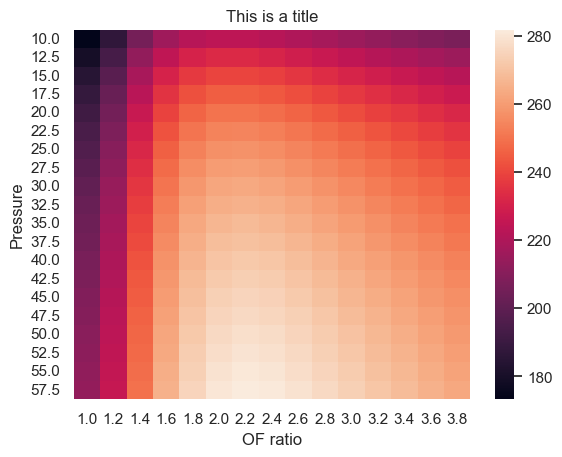

In [51]:
fig, ax = plt.subplots()
sns.set_theme()
sns.heatmap(exam.T, xticklabels=exam.index.round(2))
ax.set(xlabel='OF ratio', ylabel='Pressure', title='This is a title', )
# ax.title("This is a title")

<Axes: >

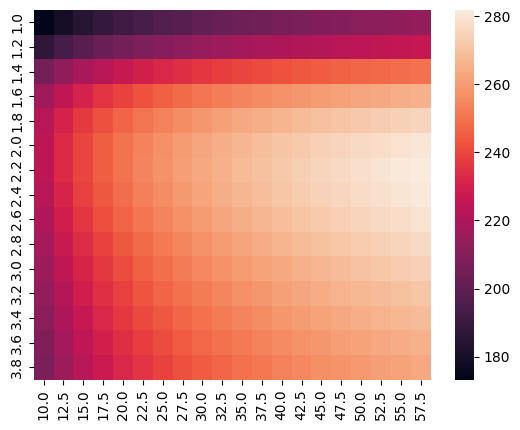

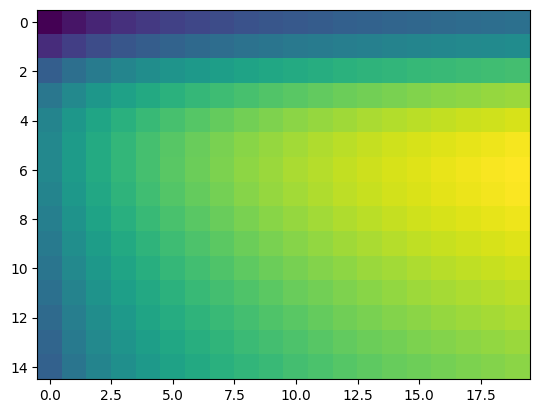

In [ ]:
plt.imshow(exam)